# Product Category Prediction Machine Learning Algorithm
**Goal/objective**: The purpose of this notebook is to utilize NLP techniques, to see if we can predict a review's product category, based on its body of text.

*Note: This is a classification problem, where we use a single string feature to perform a multi-class/label prediction on our reviews dataset*

In [2]:
from read_data import get_output_amazon_data
from read_ml_models import save_model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the Amazon reviews dataset

In [2]:
amazon_data = get_output_amazon_data()

# Train test split 

We are going to perform an 80/20 training/validation data split on our dataset. The X data frame contains a single feature column, which is the review body text. The y data frame is going to be our product categories (12 unique ones), as established from our previous exploratory data analysis. 

We are using a random state of 42, to increase the reproducibility of the exact data split that we used to train the upcoming classifier model. 

In [3]:
X = amazon_data["review_body"]
y = amazon_data["product_category"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating the Naive Bayes Model pipeline, with a TF-IDF vectorizer stage

TF-IDF (Term Frequency - Inverse Document Frequency): This is a **vectorization** strategy that employs a bag of tokens/words technique to find the documents, based on the relevance of a set of keywords in the text corpus of data we are vectorizing. It is a formulaic implementation, which is comprised of two moving parts: the **term frequency (TF)** and **inverse document frequency (IDF)**. To find the TF-IDF score of a term in a specific document, we take the product of these two values.

Sklearn luckily provides this vectorizer out of the box, so we can stick it into the first stage of the pipeline of our naive Bayes model.

We are using Naive Bayes because we have read from numerous online sources that it is a performant and versatile algorithm for text classification problems.

*Note: We will go more in-depth regarding the mathematical reasoning of picking this vectorizer for our language model and model choice in the format report*

In [3]:
bayes_clf = make_pipeline(
    TfidfVectorizer(stop_words="english", ngram_range=(1,1)),
    MultinomialNB()
) 

# Tuning our hyperparameters with GridSearchCV

The Multinomial Naive Bayes model has one key hyperparameter called the **alpha** value, which is a positive, floating point number. We are going to use  this Grid Search technique, using k-fold cross-validation to test various models/estimators on 8 different alpha values. 

Each alpha value will get 5 folds applied, based on the training data, and this refitting process gets repeated 8 times. 5 * 8 = 40 fits

In [5]:
param_grid_bayes = {"multinomialnb__alpha": [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]}
grid_clf = GridSearchCV(estimator=bayes_clf, param_grid=param_grid_bayes, cv=5, return_train_score=True, verbose=10, n_jobs=1)
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START multinomialnb__alpha=1e-05..................................
[CV 1/5; 1/8] END multinomialnb__alpha=1e-05;, score=(train=0.762, test=0.694) total time=  23.6s
[CV 2/5; 1/8] START multinomialnb__alpha=1e-05..................................
[CV 2/5; 1/8] END multinomialnb__alpha=1e-05;, score=(train=0.762, test=0.695) total time=  33.6s
[CV 3/5; 1/8] START multinomialnb__alpha=1e-05..................................
[CV 3/5; 1/8] END multinomialnb__alpha=1e-05;, score=(train=0.762, test=0.694) total time=  23.6s
[CV 4/5; 1/8] START multinomialnb__alpha=1e-05..................................
[CV 4/5; 1/8] END multinomialnb__alpha=1e-05;, score=(train=0.762, test=0.696) total time=  30.7s
[CV 5/5; 1/8] START multinomialnb__alpha=1e-05..................................
[CV 5/5; 1/8] END multinomialnb__alpha=1e-05;, score=(train=0.762, test=0.695) total time=  24.1s
[CV 1/5; 2/8] START multinomialnb__alpha=0.00

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=1,
             param_grid={'multinomialnb__alpha': [1e-05, 0.0001, 0.001, 0.1, 1,
                                                  10, 100, 1000]},
             return_train_score=True, verbose=10)

# Creating a table for the grid search mean test/training scores from the 5-folds for each alpha value

In [6]:
cv_data = grid_clf.cv_results_
cv_bayes_params = pd.DataFrame({
    "alpha_value": [param["multinomialnb__alpha"] for param in cv_data["params"]],
    "mean_test_score": cv_data["mean_test_score"],
    "mean_train_score": cv_data["mean_train_score"]
})

cv_bayes_params

,alpha_value,mean_test_score,mean_train_score
0,0.00001,0.694714,0.762311
1,0.00010,0.698859,0.761388
2,0.00100,0.703905,0.759740
3,0.10000,0.714732,0.748639
4,1.00000,0.713441,0.731531
5,10.00000,0.695869,0.703288
6,100.00000,0.657651,0.661085
7,1000.00000,0.596632,0.598193


# Creating a plot to show the relationship between the alpha hyperparameter to the accuracy score metrics

We want to pick the estimator of naive Bayes, with the alpha value that produces the highest testing/validation score from this Grid Search.

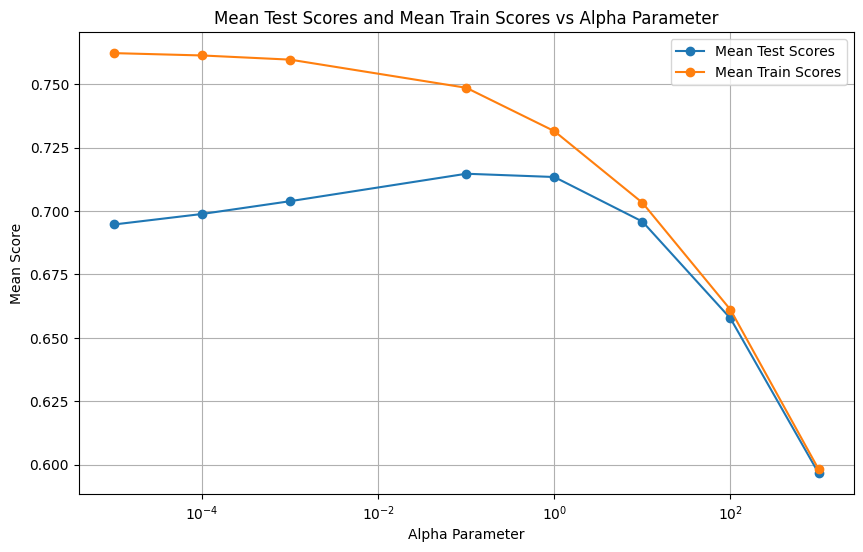

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(cv_bayes_params["alpha_value"], cv_bayes_params["mean_test_score"], label="Mean Test Scores", marker='o')
plt.plot(cv_bayes_params["alpha_value"], cv_bayes_params["mean_train_score"], label="Mean Train Scores", marker='o')
plt.xscale('log')
plt.xlabel('Alpha Parameter')
plt.ylabel('Mean Score')
plt.title('Mean Test Scores and Mean Train Scores vs Alpha Parameter')
plt.legend()
plt.grid(True)
plt.show()

It is clear from the plot that the alpha value of 0.10 has the highest mean testing score of **0.714732**

We can also see that our Naive Bayes model isn't overfitting by a large margin, due to the minimal difference between the mean training and test scores for this alpha value. The difference is less than 5%.

We have now found our **best** classifier, through this exhaustive grid search on this classification model.

In [8]:
best_bayes_model = grid_clf.best_estimator_

In [9]:
best_bayes_model.score(X_valid, y_valid)

0.7165638087817318

# Testing our product category classifier on garbage and made-up Amazon reviews, from the 12 unique products we know of

In [10]:
made_up_testing_reviews = [
    "runs perfectly on machine, and i am free of viruses now! a instant 5 stars for me",
    "my feet were too big for these! i want a refund! please have more sizes to pick from",
    "excellent storyline and gameplay mechanics. too bad the bosses are too hard",
    "the engine nearly blew up and gas tanking was leaking so hard",
    "me and my partner loved the experience. it felt extremely sensual",
    "a nice decor for my backyard. my family loves to have dinner on this delicate wooden beauty",
    "very pretty dress. i love the colors. will definitely be buying from here again in the future",
    "i am totally lost in time by this beauty. i love the golden color that it shines off my wrist",
    "i don't need a handyman anymore! this screwdriver saved me tons of time in drilling random holes into my house",
    "bounces really well! i am scoring buckets with this amazing invention. will definitely purchase for other games",
    "tasted amazing, and it saved me the trip to the store",
    "horrible battery life. takes so long to boot up. the specs are absolutely trash"
]

made_up_product_categories = best_bayes_model.predict(made_up_testing_reviews)
made_up_predictions_table = pd.DataFrame({
    "review_body": made_up_testing_reviews,
    "prediction": made_up_product_categories
})

made_up_predictions_table

,review_body,prediction
0,"runs perfectly on machine, and i am free of vi...",Software
1,my feet were too big for these! i want a refun...,Shoes
2,excellent storyline and gameplay mechanics. to...,Video Games
3,the engine nearly blew up and gas tanking was ...,Automotive
4,me and my partner loved the experience. it fel...,Personal_Care_Appliances
5,a nice decor for my backyard. my family loves ...,Furniture
6,very pretty dress. i love the colors. will def...,Apparel
7,i am totally lost in time by this beauty. i lo...,Watches
8,i don't need a handyman anymore! this screwdri...,Tools
9,bounces really well! i am scoring buckets with...,Sports


# Interpretation

Logically, it seems that our model has predicted each of these 12 categories correctly. The model is most likely able to weigh the relevance of certain keywords in the entire corpus of training reviews and be able to associate conditional probabilities of certain words with the reviews of certain product categories.

Ex: **engine** and **battery life** are most likely something a human reviewer would use when leaving a real review on the Amazon store page for the automotive and electronics categories respectively.

# Save a compressed model to disk, so it can be reused in external applications/scripts/programs

In [38]:
save_model(best_bayes_model, "product_category_bayes.joblib.gz")